In [1]:
from pulse2percept.models import AxonMapModel, BiphasicAxonMapModel, BiphasicAxonMapSpatial, Model, AxonMapSpatial
from pulse2percept.stimuli import Stimulus, BiphasicPulseTrain
from pulse2percept.implants import DiskElectrode, ProsthesisSystem, ArgusII, ElectrodeArray, ElectrodeGrid
import time
import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["JAX_LOG_COMPILES"] = '1'
# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]='1'
import jax
jax.devices()

[GpuDevice(id=0, process_index=0)]

In [2]:
from jax import jit, vmap
import jax.numpy as jnp
from pulse2percept.models import AxonMapModel, BiphasicAxonMapModel, BiphasicAxonMapSpatial, Model, AxonMapSpatial
from pulse2percept.stimuli import Stimulus, BiphasicPulseTrain
from pulse2percept.implants import DiskElectrode, ProsthesisSystem, ArgusII, ElectrodeArray
import jax
def predict_one_point(axon, brights, sizes, streaks, x, y, rho, axlambda):
    d2_el = (axon[:, 0, None] - x)**2 + (axon[:, 1, None] - y)**2
    intensities = brights * jnp.exp(-d2_el / (2. * rho**2 * sizes)) * (axon[:, 2, None] ** (1./streaks))
    return jnp.sum(intensities, axis=1)
#     return jit(vmap(predict_one_segment, in_axes=[0, None, None, None, None, None, None, None]), static_argnums=[6,7])(axon, brights, sizes, streaks, x, y, rho, axlambda)

def gpu_biphasic_axon_map(amp, freq, pdur, x, y, # Per ACTIVE electrode, (amp, freq, pdur, x, y)
                          axon_segments, rho, axlambda, thresh_percept):
    deg2rad = 3.14159265358979323846 / 180.0

#     n_space = len(axon_segments)

    min_size = 10**2 / rho**2
    min_streak = 10**2 / axlambda **2

    # First get contributions from F, G, H per electrode
    scaled_amps = amp / (0.8825 + 0.27*pdur)
    brights = 1.84*scaled_amps + 0.2*freq + 3.0986
    sizes = jnp.maximum(1.081*scaled_amps - 0.3533764, min_size)
    streaks = jnp.maximum(1.56 - 0.54 * pdur ** 0.21, min_streak)

#     # axon_segments is (n_space, axon_length, 3), x and y are (n_elec)
#     d2_el = (axon_segments[:, :, 0, None] - params[3])**2 + (axon_segments[:, :, 1, None] - params[4])**2
#     # (n_space, axon_length, n_elecs)
    
#     #                       (n_elecs) (n_space, axon_length, n_elecs)            (n_space, axon_length, n_elecs) 
#     electrode_intensities = brights * jnp.exp(-d2_el / ( 2. * rho**2. * sizes)) * (axon_segments[:, :, 2, None] ** (1. / streaks))
#     # (n_space, axon_length, n_elecs)
    
# #     axon_intensities = 
#     # (n_space, n_elecs)
#     I = np.sum(electrode_intensities, axis=2)
    
    
    
    
    I = jnp.max(jit(vmap(predict_one_point, in_axes=[0, None, None, None, None, None, None, None]))(axon_segments, brights, sizes, streaks, x, y, rho, axlambda), axis=1)
    I = (I > thresh_percept) * I
    return I
from copy import deepcopy
from pulse2percept.percepts import Percept
class BiphasicAxonMapGPUSpatial(AxonMapSpatial):
    def __init__(self, **params):
        super(BiphasicAxonMapGPUSpatial, self).__init__(**params)

    def _predict_spatial(self, earray, stim):
#         start = time.time()
        assert isinstance(earray, ElectrodeArray)
        assert isinstance(stim, Stimulus)

        # get relevant stimulus properties
        amps = np.array([stim.metadata['electrodes'][str(e)]['metadata']['amp'] for e in stim.electrodes], dtype="float32")
        freqs = np.array([stim.metadata['electrodes'][str(e)]['metadata']['freq'] for e in stim.electrodes], dtype="float32")
        pdurs = np.array([stim.metadata['electrodes'][str(e)]['metadata']['phase_dur'] for e in stim.electrodes], dtype="float32")

        x = np.array([earray[e].x for e in stim.electrodes], dtype=np.float32)
        y = np.array([earray[e].y for e in stim.electrodes], dtype=np.float32)
        
        params = np.vstack([amps, freqs, pdurs, x, y])
#         begin = time.time()
#         print("Setup time: %.3fms" % ((begin - start)*1000))
#         params = jax.device_put(params, jax.devices()[0])
#         ax_contrib = jax.device_put(self.axon_contrib, jax.devices()[0])
#         ax_contrib = self.axon_contrib
        e1 = time.time()
#         print("Transfer time: %.3fms" % ((e1 - begin)*1000))
        p =  jit(gpu_biphasic_axon_map, static_argnums=[6, 7, 8])(amps, freqs, pdurs, x, y,
                                     self.axon_contrib,
                                     self.rho, self.axlambda, self.thresh_percept)
        end = time.time()
#         print("Jax time: {} ms on sample {}".format((end - begin) * 1000, stim.shape))

        return (end - e1) * 1000

    def _build(self):
        super(BiphasicAxonMapGPUSpatial, self)._build()
        self.axon_contrib = jax.device_put(self.axon_contrib, jax.devices()[0])
        



class BiphasicAxonMapGPU(Model):
    def __init__(self, **params):
        super(BiphasicAxonMapGPU, self).__init__(spatial=BiphasicAxonMapGPUSpatial(), temporal=None, **params)

    def predict_percept(self, implant, t_percept=None):
#         start = time.time()
        # Make sure stimulus is a BiphasicPulseTrain:
        if not isinstance(implant.stim, BiphasicPulseTrain):
            # Could still be a stimulus where each electrode has a biphasic pulse train
            for ele, params in implant.stim.metadata['electrodes'].items():
                if params['type'] != BiphasicPulseTrain or params['metadata']['delay_dur'] != 0: 
                    raise TypeError("All stimuli must be BiphasicPulseTrains with no delay dur (Failing electrode: %s)" % (ele)) 
        
#         return super(BiphasicAxonMapGPU, self).predict_percept(implant, t_percept=t_percept)

        if not self.is_built:
            raise NotBuiltError("Yout must call ``build`` first.")
        if not isinstance(implant, ProsthesisSystem):
            raise TypeError(("'implant' must be a ProsthesisSystem object, "
                             "not %s.") % type(implant))

        # Calculate the Stimulus at requested time points:

        stim = Stimulus(implant.stim) # make sure stimulus is in proper format

#         e4 = time.time()
#         print("Stim restructuring and checks: %.3fms" % ((e4 - start) * 1000))
        
        resp = self._predict_spatial(implant.earray, stim)
        return resp
#         e5 = time.time()
#         print("predict_spatial: %.3fms" % ((e5 - e4) * 1000))
        p = Percept(resp.reshape(list(self.grid.x.shape) + [-1]),
                       space=self.grid, time=None,
                       metadata={'stim': stim.metadata})
#         e6 = time.time()
#         print("Percept Construction: %.3fms" % ((e6 - e5) * 1000))
        return p

    def predict_percept_batched(self, implant, stim_list, t_percept=None):
        start = time.time()
        for stim in stim_list:
            if not isinstance(stim, BiphasicPulseTrain):
                # Could still be a stimulus where each electrode has a biphasic pulse train
                for ele, params in stim.metadata['electrodes'].items():
                    if params['type'] != BiphasicPulseTrain or params['metadata']['delay_dur'] != 0: 
                        raise TypeError("All stimuli must be BiphasicPulseTrains with no delay dur (Failing electrode: %s)" % (ele)) 
        
        if not self.is_built:
            raise NotBuiltError("You must call ``build`` first.")
        if not isinstance(implant, ProsthesisSystem):
            raise TypeError(("'implant' must be a ProsthesisSystem object, "
                             "not %s.") % type(implant))
        
        batch = []
        for stim in stim_list:   
            amps = np.array([stim.metadata['electrodes'][str(e)]['metadata']['amp'] for e in stim.electrodes], dtype="float32")
            freqs = np.array([stim.metadata['electrodes'][str(e)]['metadata']['freq'] for e in stim.electrodes], dtype="float32")
            pdurs = np.array([stim.metadata['electrodes'][str(e)]['metadata']['phase_dur'] for e in stim.electrodes], dtype="float32")
            x = np.array([implant.earray[e].x for e in stim.electrodes], dtype=np.float32)
            y = np.array([implant.earray[e].y for e in stim.electrodes], dtype=np.float32)

            batch.append(np.vstack([amps, freqs, pdurs, x, y]))
        
        batch = np.array(batch) 
        e1 = time.time()
        print("Setup: %.3fms" % ((e1 - start) * 1000))
#         print(batch.shape)
        start = time.time()
#         print("Transfer: %.3fms" % ((start - e1) * 1000))
        resps = jit(vmap(gpu_biphasic_axon_map, in_axes=[0, None, None, None, None]), static_argnums=[2,3,4])(batch, self.axon_contrib, self.rho, self.axlambda, self.thresh_percept).block_until_ready()
        end = time.time()
        print("Jax time: %.3f ms, %.3f ms per sample" % (float(end - start) * 1000, float((end - start) * 1000 / len(stim_list))))


In [3]:
import time
import random
import math
from pulse2percept.stimuli import Stimulus, BiphasicPulseTrain

batch = None
batched_size = None
n_elec_size = None
def rand_stim(implant, n_electrodes=1, shorten=True, verbose=True, stripped = True):
    maxamp = 15
    maxfreq = 200
    elecs = set()
    elecs.update(random.sample(list(implant.electrode_names), n_electrodes))
    
    stim = {}
    for elec in elecs:
        estim = None
        while estim is None:
            amp = random.random() * maxamp
            freq = random.random() * maxfreq
            pdur = random.expovariate(1)
            while pdur > 1000 / freq / 2 or pdur < 0.01 or pdur > 100:
                pdur = random.expovariate(1)
            if stripped:
                estim = (freq, amp, pdur)
            else:
                try:
                    if shorten:
                        estim = BiphasicPulseTrain(freq, amp, pdur, stim_dur=math.ceil(3*pdur))
                    else:
                        estim = BiphasicPulseTrain(freq, amp, pdur, stim_dur=250)
                except Exception as e:
                    if verbose: 
                        print("bad stim {}".format((freq, amp, pdur)))
                    estim = None
                    continue
        stim[elec] = estim
        
    if not stripped:
        stimulus = Stimulus(stim)
    else:
        stimulus = np.array([i for i in stim.values()], dtype=np.float32), np.array([implant[e].x for e in stim.keys()], dtype=np.float32), np.array([implant[e].y for e in stim.keys()], dtype=np.float32)
    return stimulus

def time_constant(model, implant, n_elecs=1, n_samples=10, stim_func=rand_stim, verbose=True, shorten=True, stripped=True):
    total_time = 0
    stim_time = 0
    for i in range(n_samples):
        try:
            start = time.time()
            stim = stim_func(implant, n_electrodes=n_elecs, shorten=shorten, verbose=verbose, stripped = stripped)
            
            stim_time += time.time() - start
            start = time.time()
            if not stripped:
                implant.stim = stim
                percept = model.predict_percept(implant)
            else:
                percept = model.spatial._predict_spatial_jax(stim[0], stim[1], stim[2]).block_until_ready()
            end = time.time()
            # print(f"outer loop time: {round((end - start) * 1000, 1)}ms")
            # print()
            total_time += end - start
        except Exception as e:
            i -= 1
            print(e)
            raise e
            # continue
    if verbose:
        print("Average stimulus creation time: %.2fms" % (stim_time / n_samples * 1000))
        print("Average prediction time (%d electrodes): %.2fms" % (n_elecs, total_time / n_samples * 1000))
        print("Average prediction time per electrode: %.2fms" % (total_time / n_samples * 1000 / n_elecs))
    return total_time / n_samples * 1000

def time_batch(model, implant, n_elecs=1, batch_size=256, stim_func=rand_stim, verbose=True, stripped=True, shorten=True):
    global batch, batched_size, n_elec_size
    if batch is None or batched_size != batch_size or n_elecs != n_elec_size: # use precomputed batch if possible
        stim_list = []
        for i in range(batch_size):
            try:
                stim_list.append(stim_func(implant, n_electrodes=n_elecs, stripped = stripped, shorten=shorten))
            except Exception as e:
                i -= 1
                print(e)
                continue
        if stripped:
            eparams = np.array([l[0] for l in stim_list])
            x = np.array(stim_list[0][1])
            y = np.array(stim_list[0][2])
            batch = (eparams, x, y)
            stim_list = batch
        else:
            batch = stim_list
        batched_size = batch_size
    else:
        stim_list = batch
    
    if verbose:
        print("predicting percepts")
    start = time.time()
    if not stripped:
        t = model.predict_percept_batched(implant, stim_list)
    else:
        t = model.spatial._predict_spatial_batched(stim_list[0], stim_list[1], stim_list[2]).block_until_ready()
        
    end = time.time()
    total_time = end - start
    if verbose:
        print("Average prediction time (%d electrodes): %.2fms" % (n_elecs, total_time / batch_size * 1000))
        print("Total batch time: %.3fms" % ((end - start)* 1000))
    return total_time * 1000

## Setup

In [4]:
model = BiphasicAxonMapModel(axlambda=800, engine='jax', min_ax_sensitivity=5e-3)
model.build()
implant = ProsthesisSystem(ElectrodeGrid((50, 50), 120, r=40, names=('A', '1'), type='hex', etype=DiskElectrode))
stim = Stimulus({ "A10" : BiphasicPulseTrain(30, 1, 0.45)})
# stim = Stimulus({"A5" : BiphasicPulseTrain(20, 1, 0.45), "A10" : BiphasicPulseTrain(30, 1, 0.45), "A4" : BiphasicPulseTrain(20, 1, 0.45)})
implant.stim = stim

In [10]:
start = time.time()
percept = model.predict_percept(implant)
real_time = (time.time() - start)*1000
print(f"Took {round(real_time, 1)}ms")

Took 1.6ms


In [12]:
time_constant(model, implant, n_elecs=1000, n_samples=10)

Average stimulus creation time: 3.55ms
Average prediction time (1000 electrodes): 20.03ms
Average prediction time per electrode: 0.02ms


20.028257369995117

In [21]:
resps = time_batch(model, implant, n_elecs=15, batch_size=256)

predicting percepts
Average prediction time (15 electrodes): 58.56ms
Total batch time: 14991.248ms


### Make sure theyre the same

In [22]:
m1 = BiphasicAxonMapModel(axlambda=800, engine='cython', min_ax_sensitivity=5e-3)
m1.build()
p1 = m1.predict_percept(implant)
np.max(np.abs(p1.data - percept.data))

1.1920928955078125e-07

## Plots

Note: Run twice to get best times (compile)

In [4]:
import matplotlib.pyplot as plt
model = BiphasicAxonMapModel(axlambda=800, engine='jax', min_ax_sensitivity=5e-3)
model.build()
implant = ProsthesisSystem(ElectrodeGrid((75, 75), 120, r=40, names=('A', '1'), type='hex', etype=DiskElectrode))

#### Scaling number of electrodes

Text(0.5, 0, 'Number of Electrodes')

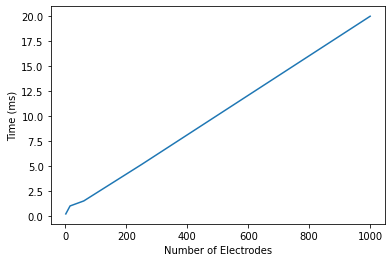

In [65]:
test_elecs = [1, 15, 60, 250, 1000]
times = []
for n_elecs in test_elecs:
    times.append(time_constant(model, implant, n_elecs=n_elecs, n_samples=30, verbose=False))
plt.plot(test_elecs, times)
plt.ylabel("Time (ms)")
plt.xlabel("Number of Electrodes")
# plt.xscale('log')

#### Scaling number of percepts (batch size), 60 active electrodes

Text(0.5, 0, 'Batch size (60 active electrodes each)')

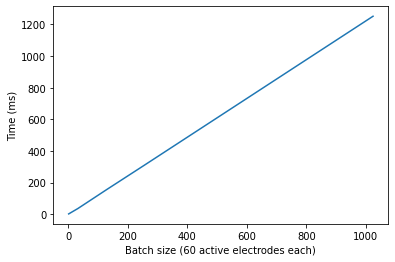

In [15]:
test_vals = [1, 32, 128, 256, 1024]
times = []
for test_val in test_vals:
    times.append(time_batch(model, implant, n_elecs=60, batch_size=test_val, verbose=False))
plt.plot(test_vals, times)
plt.ylabel("Time (ms)")
plt.xlabel("Batch size (60 active electrodes each)")
# plt.xscale('log')

Text(0.5, 0, 'Batch size (60 active electrodes each)')

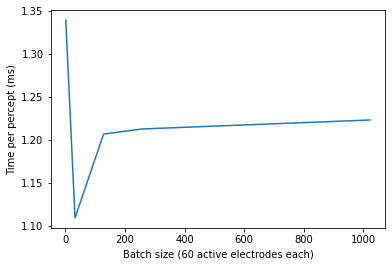

In [16]:
plt.plot(test_vals, [times[i] / test_vals[i] for i in range(len(times))])
plt.ylabel("Time per percept (ms)")
plt.xlabel("Batch size (60 active electrodes each)")

#### Scaling percept size (xystep)

Text(0.5, 0, 'Number of points')

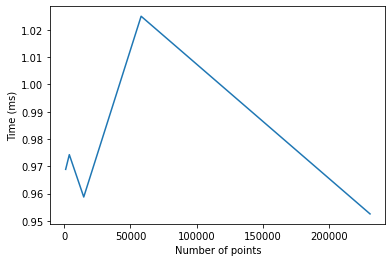

In [48]:
test_vals = [1, 0.5, 0.25, 0.125, 0.125/2]
times = []
for test_val in test_vals:
    model.xystep = test_val
    model.build()
    time_constant(model, implant, n_elecs=15, verbose=False)
    t = time_constant(model, implant, n_elecs=15, verbose=False)
    times.append(t)
plt.plot([((np.diff(model.grid.x_range) / xystep)+1)**2 for xystep in test_vals], times)
plt.ylabel("Time (ms)")
plt.xlabel("Number of points")

### Again for cpu

In [4]:
import matplotlib.pyplot as plt
model = BiphasicAxonMapModel(axlambda=800, engine='jax', min_ax_sensitivity=5e-3)
model.build()
implant = ProsthesisSystem(ElectrodeGrid((75, 75), 120, r=40, names=('A', '1'), type='hex', etype=DiskElectrode))

#### Scaling number of electrodes

Text(0.5, 0, 'Number of Electrodes')

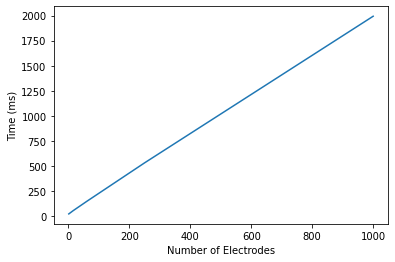

In [5]:
test_elecs = [1, 15, 60, 250, 1000]
times = []
for n_elecs in test_elecs:
    times.append(time_constant(model, implant, n_elecs=n_elecs, n_samples=30, verbose=False))
plt.plot(test_elecs, times)
plt.ylabel("Time (ms)")
plt.xlabel("Number of Electrodes")
# plt.xscale('log')

#### Scaling number of percepts (batch size), 60 active electrodes

In [ ]:
test_vals = [1, 32, 128, 256, 1024]
times = []
for test_val in test_vals:
    times.append(time_batch(model, implant, n_elecs=60, batch_size=test_val, verbose=False))
plt.plot(test_vals, times)
plt.ylabel("Time (ms)")
plt.xlabel("Batch size (60 active electrodes each)")
# plt.xscale('log')

In [ ]:
plt.plot(test_vals, [times[i] / test_vals[i] for i in range(len(times))])
plt.ylabel("Time per percept (ms)")
plt.xlabel("Batch size (60 active electrodes each)")

#### Scaling percept size (xystep)

In [ ]:
test_vals = [1, 0.5, 0.25, 0.125]
times = []
for test_val in test_vals:
    model.xystep = test_val
    model.build()
    time_constant(model, implant, n_elecs=15, verbose=False)
    t = time_constant(model, implant, n_elecs=15, verbose=False)
    times.append(t)
plt.plot([((np.diff(model.grid.x_range) / xystep)+1)**2 for xystep in test_vals], times)
plt.ylabel("Time (ms)")
plt.xlabel("Number of points")

In [19]:
set().union(*[[1,2,3], [2,3,4], [5]])

{1, 2, 3, 4, 5}